# Bank Predictioins

# Step 2: Discover

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as sp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

## Obtaining the Data

In [2]:
import sys

sys.path.insert(0, '/scripts/')
from scripts.helpers import load_data, find_outliers, classifier_categorical_variance, \
    plot_success_rates, bank_profit, cat_null_cleaner, cat_small_counts
from scripts.NaiveClassifier import NaiveClassifier
from scripts.Preprocessing import Preprocessing

In [3]:
path = './raw_data/'
file = 'bank-full.csv'
bank_data = load_data(path=path, file=file, verbose=True, sep=';')

--------------------------------bank-full shape---------------------------------
                                  (41188, 21)                                   


----------------------------bank-full's column types----------------------------
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


---------------------------bank-full first five rows----------------------------
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic

## Cleaning the Data

There is an incredibly small probability that any rows which are exactly the same represent two distinct clients, so I will be dropping any duplicated rows.

In [4]:
bank_data.drop_duplicates(inplace=True)
bank_data.shape

(41176, 21)

In [5]:
bank_data.dropna(inplace=True)
bank_data.shape

(41176, 21)

In [6]:
bank_data.drop('duration', axis=1, inplace=True)
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Please refer to my discussion [here](./01_Define.ipynb#Dropping-'duration') for an explanation as to why I am dropping the column "duration." 

The description for *campaign* mentions that it includes the last contact with the client during this campaign. Since I am predicting whether they will be subscribing to a term deposit on their last contact, then I need to remove it from the column. The column *previous* also has this issue.

In [7]:
bank_data['campaign'] -= 1
bank_data['previous'] -= 1

In [8]:
bank_data[['campaign', 'previous']].describe()

,campaign,previous
count,41176.000000,41176.000000
mean,1.567879,-0.826987
std,2.770318,0.494964
min,0.000000,-1.000000
25%,0.000000,-1.000000
50%,1.000000,-1.000000
75%,2.000000,-1.000000
max,55.000000,6.000000


This shows that quite a lot of people have not been contacted during this current campaign. The -1 values in *previous* indicate that they were never contacted in a prior campaign. This data is already held in the *poutcome* value nonexistent.

In [9]:
bank_data[bank_data['previous'] != -1].y.value_counts()

no     4126
yes    1499
Name: y, dtype: int64

In [10]:
bank_data[bank_data['poutcome'] != 'nonexistent'].y.value_counts()

no     4126
yes    1499
Name: y, dtype: int64

I'll move on for now, but I may come back to investigate *previous* further.

### Cleaning the Data, Missing Values

I have dropped all null values from the dataframe above utilizing the *dropna* method. But, this only takes care of values for which pandas recognizes a missing value (generally the None python object or np.nan). There currently are values in the data which are unknown, and I need to decide whether or not I need to fix this. An example of this type of unknown is *pdays* value of 999 as can be seen in the brief look at the data above. These values need to either be imputed, removed, or potentially left alone to help with the performance of the models.

In [11]:
clean_cols = {'poutcome': 'nonexistent',
              'job': 'unknown',
              'marital': 'unknown',
              'education': 'unknown',
              'default': 'unknown',
              'housing': 'unknown',
              'loan': 'unknown'}
drop_cols, drop_rows = cat_null_cleaner(df=bank_data, null_vals=clean_cols, target='y')
print(drop_cols)

[]


In [12]:
bank_data.shape

(41176, 20)

In [13]:
rows_to_drop = set([])
for rows in drop_rows:
    rows_to_drop |= set(rows.values)
bank_data.drop(rows_to_drop, inplace=True)
bank_data.drop(drop_cols, axis=1, inplace=True)
bank_data.shape

(38234, 20)

#### Cleaning the Data, Missing Values, pdays

In [14]:
bank_data[bank_data.pdays==999].shape[0] / bank_data.shape[0]

0.9642726369200189

Roughly 96% of the pdays column is the value 999. All of these customers were never previously contacted in a campaign. This data has already been captured in the *poutcome* feature since their previous outcome would just be "nonexistent." I believe it is safe to asssume that this column can be dropped without much consequence.

In [15]:
bank_data[(bank_data.poutcome=='nonexistent') & (bank_data.pdays==999)].shape[0] / \
    bank_data[bank_data.poutcome=='nonexistent'].shape[0]

1.0

In [16]:
bank_data.drop('pdays', axis=1, inplace=True)

Now, I need to group the smaller counts of data together so that I'm not losing information and ensuring there is enough data for each smaller count for the algorithms to learn something. For example, the 3 clients who are in default won't really add much to the data set.

In [17]:
cat_cols = [x for x in bank_data.columns if bank_data[x].dtype==object and x != 'y']

for col in cat_cols:
    print(f"Column name: {col}")
    print(bank_data[col].value_counts() / bank_data[col].shape[0])
    print()

Column name: job
admin.           0.259821
blue-collar      0.223858
technician       0.166763
services         0.097139
management       0.071350
retired          0.041220
entrepreneur     0.035570
self-employed    0.035283
housemaid        0.025815
unemployed       0.025187
student          0.017994
Name: job, dtype: float64

Column name: marital
married     0.606188
single      0.281320
divorced    0.112491
Name: marital, dtype: float64

Column name: education
university.degree      0.309070
high.school            0.241696
basic.9y               0.153162
professional.course    0.133311
basic.4y               0.104671
basic.6y               0.057619
illiterate             0.000471
Name: education, dtype: float64

Column name: default
no         0.797065
unknown    0.202856
yes        0.000078
Name: default, dtype: float64

Column name: housing
yes    0.538081
no     0.461919
Name: housing, dtype: float64

Column name: loan
no     0.844144
yes    0.155856
Name: loan, dtype: float64

C

In [18]:
cat_small_counts(df=bank_data, cat_cols=cat_cols, min_frac=.1, max_frac=.9, inplace=True)
for col in cat_cols:
    print(f"Column name: {col}")
    print(bank_data[col].value_counts())
    print()

Column name: job
other          12769
admin.          9785
blue-collar     7167
technician      6292
Name: job, dtype: int64

Column name: marital
married     21451
single      10437
divorced     4125
Name: marital, dtype: int64

Column name: education
university.degree      11817
high.school             9241
basic.9y                5856
professional.course     5097
basic.4y                4002
Name: education, dtype: int64

Column name: default
no        29076
not no     6937
Name: default, dtype: int64

Column name: housing
yes        19407
not yes    16606
Name: housing, dtype: int64

Column name: loan
no        30383
not no     5630
Name: loan, dtype: int64

Column name: contact
cellular        23199
not cellular    12814
Name: contact, dtype: int64

Column name: month
may      11796
jul       6193
aug       5676
jun       4534
other     4078
nov       3736
Name: month, dtype: int64

Column name: day_of_week
thu    7527
mon    7519
wed    7121
tue    7028
fri    6818
Name: day_of_w

If a category was less than 10% of the data, then it was either combined with other smaller categories to create an "other" value or it was removed from the data. In the case that a category dominated the data so much, then it was changed into a binary feature rather than 3 small-ish categories with one large one. 

## Exploring the Data

The first thing I want to do is to compare the counts of whether a client subscribed or not to a term deposit. This is to make sure that both subscribed and not subscribed will be equally represented in the model.

Rejection rate: 0.887%
Subscription rate: 0.113%
Number of Subscribers: 4073
Number of Rejections: 31940


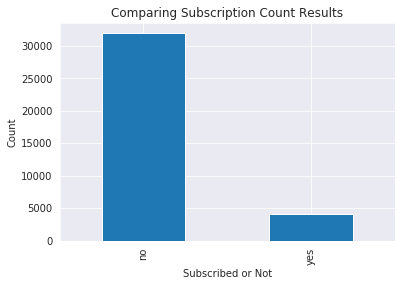

In [19]:
target_col = bank_data['y']
count = target_col.value_counts()

sns.set_style("darkgrid")
ax = count.plot(kind='bar')
ax.set_ylabel("Count")
ax.set_xlabel("Subscribed or Not")
ax.set_title("Comparing Subscription Count Results")



print(f'Rejection rate: {count["no"] / count.sum():.3f}%')
print(f'Subscription rate: {count["yes"] / count.sum():.3f}%')
print(f'Number of Subscribers: {count["yes"]}')
print(f'Number of Rejections: {count["no"]}')

As expected for a marketing campaign, the number of rejections clearly outweigh the number of people who subscribed to a term deposit with roughly 89% of the data being rejections. To get a more accurate model, it would be best to make it so that both the positive and negative results are roughly equivalent. I can achieve this by either downsampling the rejections or upsampling the subscriptions. I will be upsampling the subscriptions because there would be too large of a loss of information if I took a random sample of the rejections. The method I will be using to upsample the data is [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE), and it will be applied to the training data after it has been preprocessed and split into training and validation data in the next notebook.

### Exploring the Data, Categorical Features

There could potentially be a few numerical columns that should be used as categorical features based on their number of unique values.

In [20]:
num_unique = bank_data.drop(columns='y').nunique()
num_unique

age                76
job                 4
marital             3
education           5
default             2
housing             2
loan                2
contact             2
month               6
day_of_week         5
campaign           41
previous            8
poutcome            2
emp.var.rate       10
cons.price.idx     26
cons.conf.idx      26
euribor3m         314
nr.employed        11
dtype: int64

In [21]:
cat_cols = num_unique[num_unique < 8].index
bank_data[cat_cols] = bank_data[cat_cols].astype('str')

I chose to only hve objects with less than 8 unique values become categorical values because most of the low frequency numerical columns will have a right skewed distribution where the higher the number, the more likely it is that they have decided to subscribe to a term deposit. I want to ensure that these lower frequency values will be used properly in the classification. This cannot happen if the feature is categorical rather than numerical. If I decide to make some of the numerical columns closer to categorical columns, I will utilize binning.

In [22]:
num_unique = bank_data.drop(columns='y').nunique()
cat_cols = num_unique[num_unique < 8].index
cat_small_counts(df=bank_data, cat_cols=list(cat_cols), min_frac=.03, max_frac=.9, inplace=True)
cat_variances = classifier_categorical_variance(df=bank_data, 
                                                cat_cols=cat_cols,
                                                target_col='y', pos_val='yes')
cat_variances

,no,yes
poutcome,0.0150641,0.0150641
month,0.00879085,0.00879085
contact,0.0043874,0.0043874
default,0.00295492,0.00295492
job,0.00080938,0.00080938
education,0.000448642,0.000448642
marital,0.000375887,0.000375887
day_of_week,6.71773e-05,6.71773e-05
housing,2.03614e-05,2.03614e-05
loan,6.97616e-06,6.97616e-06


As we can see, there is a greater variety in outcome rate for variables *poutcome* and *month* whereas features *day_of_week*, *housing*, and *loan* don't vary much at all. The variables with low variance will be quite useless when doing the analysis and can be safely removed from the dataset.

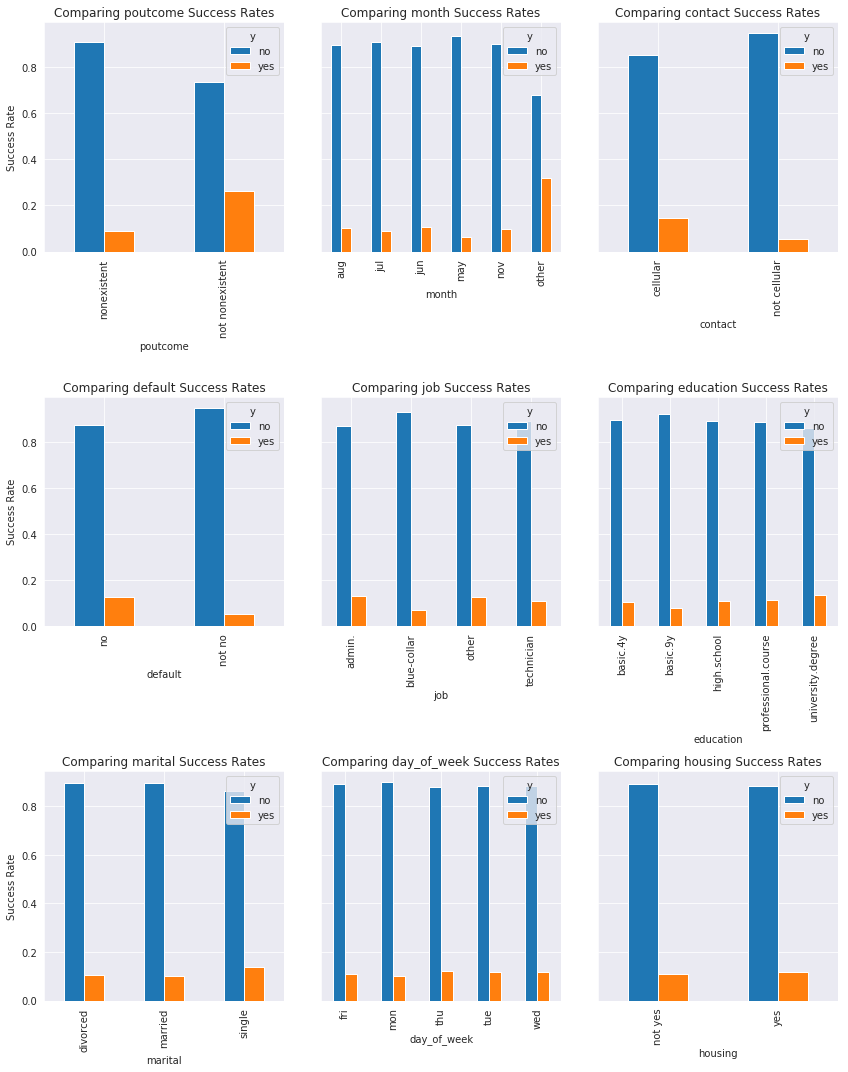

In [23]:
plot_success_rates(df=bank_data, cat_cols=cat_variances.index[:9], target_col='y', num_cols=3)

### Exploring the Data, Numeric Features

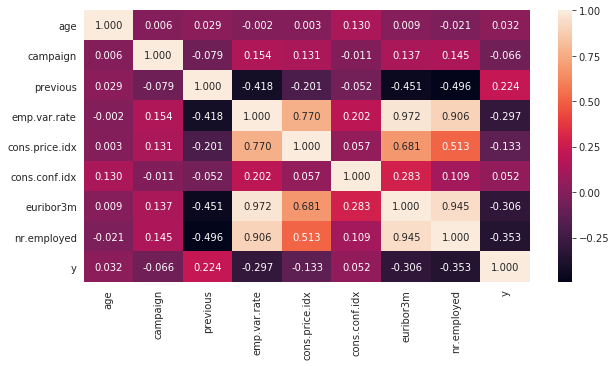

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

bank_data['y'] = le.fit_transform(bank_data.y)
# test = bank_data.pdays.replace(to_replace=999, value=20)
num_bank_data = bank_data[
    [x for x in bank_data.columns if x not in cat_cols or x =='y']] \
    .copy()

fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(num_bank_data.corr(), annot=True, fmt='.3f')

It looks like values like *age* and *campaign* do not really help us explain anything about the subscribers. I will make some plots to see if they agree.

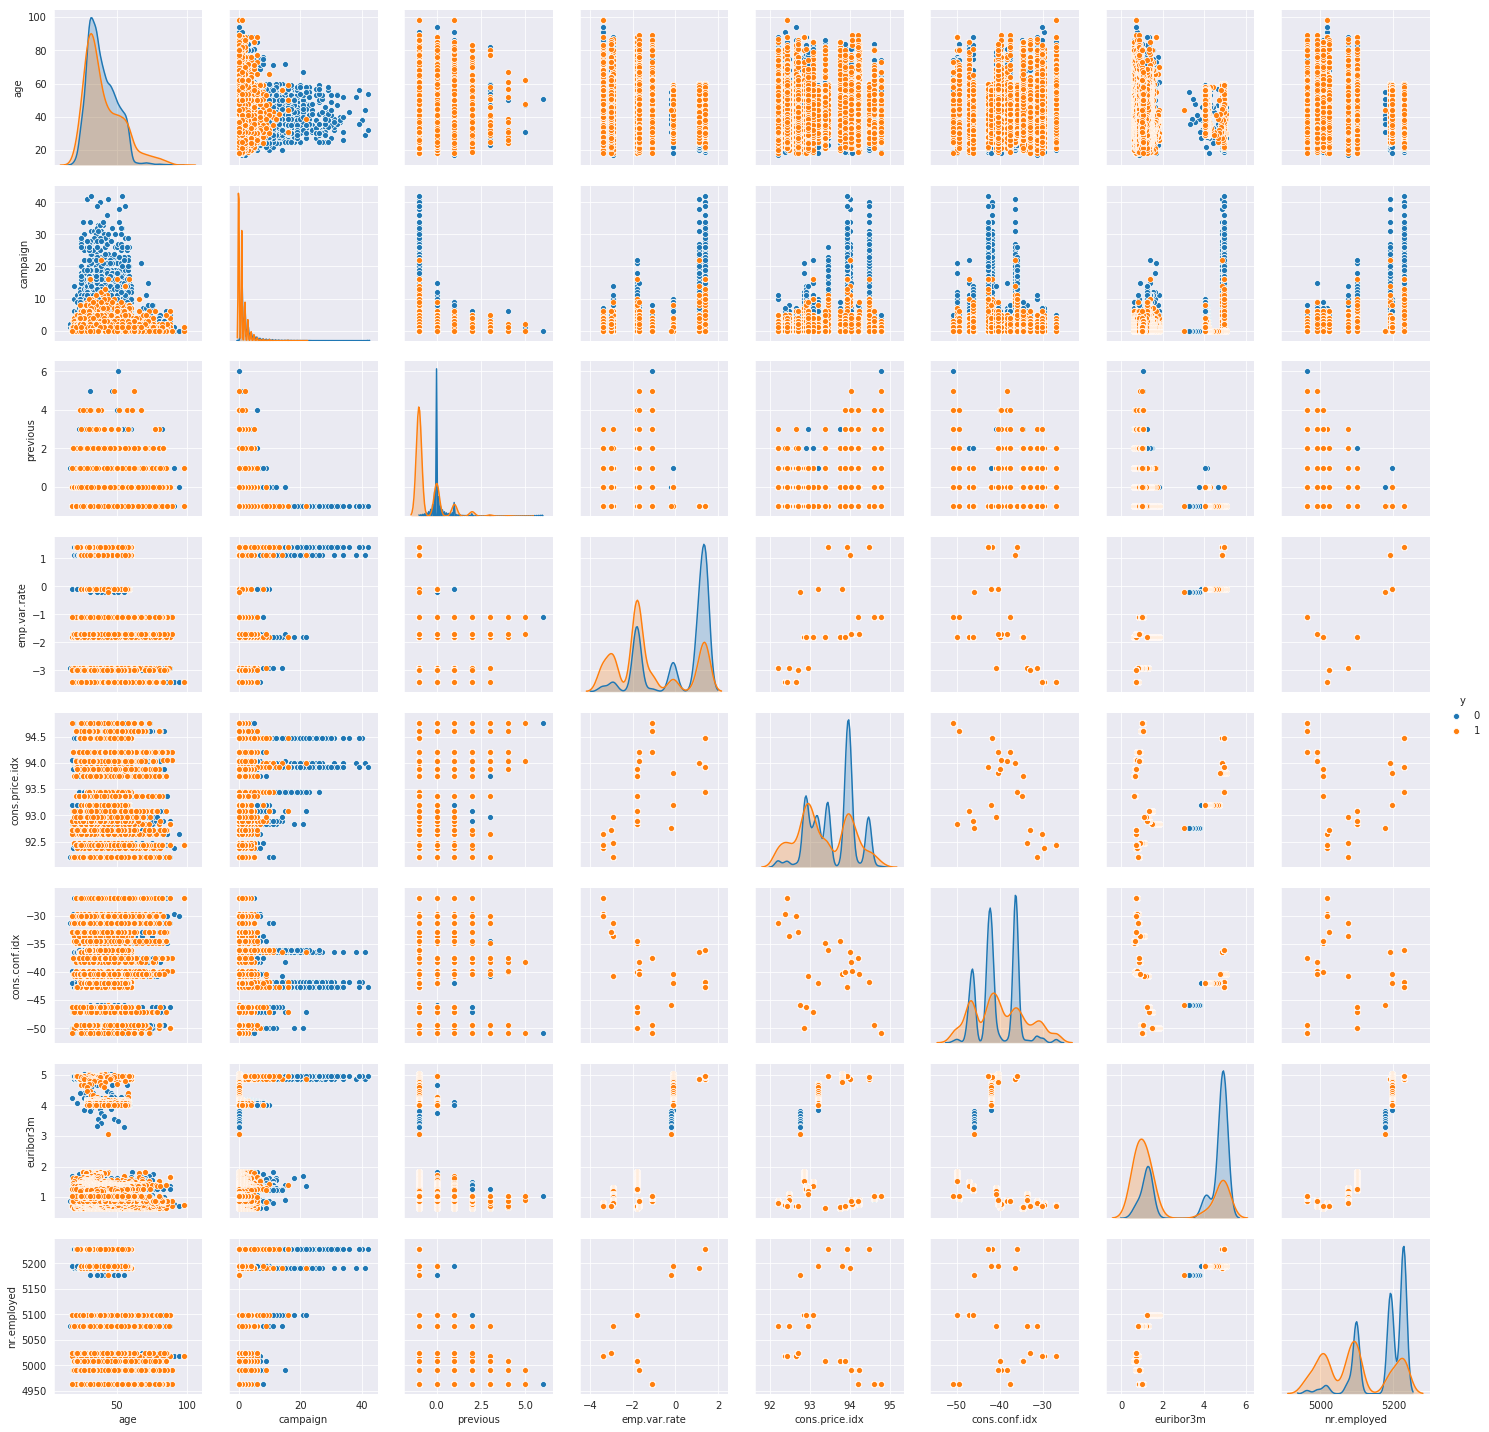

In [25]:
sns.pairplot(num_bank_data, vars=num_bank_data.columns.drop('y'), hue='y')

This visualization is going to help me understand how the different variables interact with eachother as well as how the data is spread between the subscribed and not subscribed for each variable. The diagonal plots illustrate this spread. Key things to look for is when the the two colors are highly separated, preferably more orange and less blue. These areas will display for what values there were more people subscribing to term deposits than not. Take for instance *nr.employed* in the bottom right. At around 5000, there was a much larger fraction of clients subscribing for term deposits than not.

This plot also illustrates why features like *age* and *campaign* do not have a high correlation. There is relatively low separation with both of these values, and they should safely be dropped.

In [26]:
bank_data.drop(columns=['age', 'campaign'], inplace=True)

In [27]:
from math import ceil
def plot_histograms(df, cols, fig_num_cols=3):
    n_cols = fig_num_cols
    n = len(cols)
    n_rows = ceil(n/n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows), sharey=True)
    
    for col, ax in zip(cols, axes.flatten()):
        df[col].hist(ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
        ax.set_title(f'{col} histogram')
    
    for i in range(n, len(axes.flatten())):
        fig.delaxes(axes.flatten()[i])
    
    plt.tight_layout()
    plt.show()
    return axes

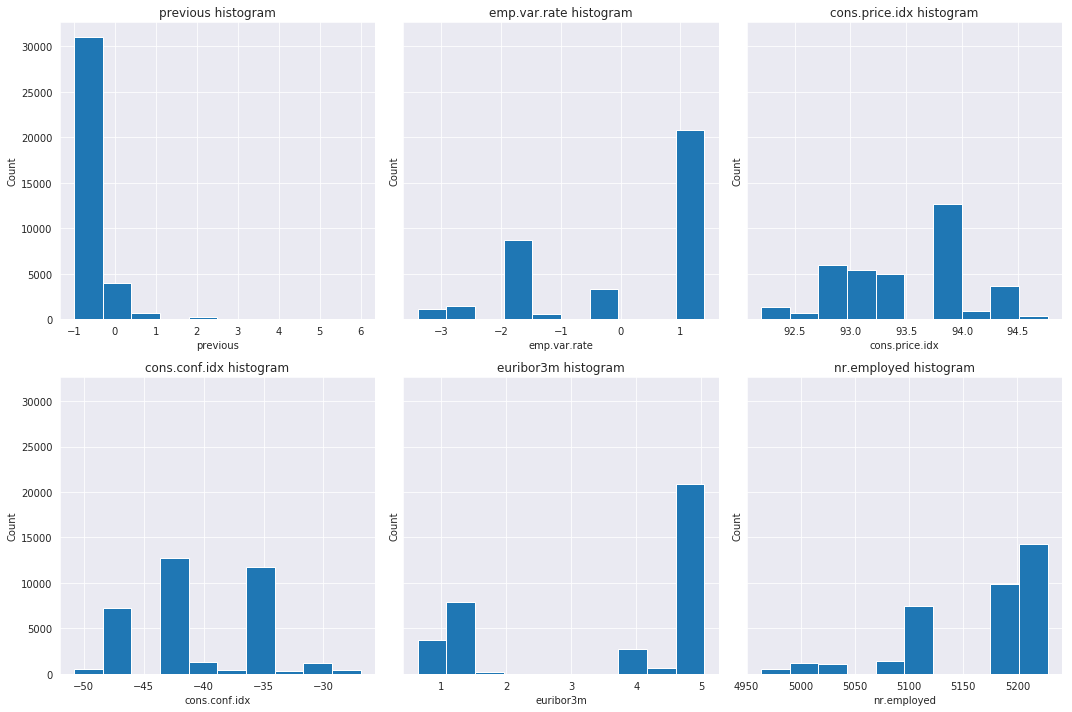

In [28]:
hists = plot_histograms(df=bank_data, cols=num_bank_data.columns.drop(['y', 'age', 'campaign']))

In [29]:
binned_cols = {'nr.employed': 3, 'cons.conf.idx': 4, 'cons.price.idx': 2}

The binned columns above seem to be the most appropriate due to the distributions of each feature. I've only binned these because they have a variety of values for each bin. Also, lower counts like *previous* are better left as purely numeric. *euribor3m* has such a tight distribution that splitting it into 2 bins (2 due to the bimodal distribution) would make me lose information.

## Establishing a Baseline Outcome

To illustrate how accuracy can be a misleading metric, I will measure it for a model which would clearly be horrible for the bank to implement.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

X_train, X_test, y_train, y_test = train_test_split(
    bank_data.drop('y', axis=1), 
    bank_data['y'],
    random_state=1234)

lb = LabelBinarizer()
lb.fit_transform(y_train)
y_test = pd.Series(lb.transform(y_test).ravel(), name='y')

nc = NaiveClassifier()
nc.fit(X_train, y_train)
y_pred = nc.predict(X_test)

np.unique(y_pred, return_counts=True)

(array([0]), array([9004]))

Alright, my naive model has predicted the majority case of *not subscribed* for every client in the test data. Now, I need to calculate the accuracy and profit score for the naive model.

In [31]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
profit = bank_profit(y_test, y_pred)

print(f"Accuracy: {acc:.2f}")
print(f"Profit Score: {profit:.2f}")

Accuracy: 0.89
Profit Score: 0.00


If I had naively assumed accuracy to be the best measurement for the classifier, I might have seen .90 accuracy and rejoiced in the outcome. But, profit score gives a much bleaker result for the model. The score is quite abysmal, and it is an indication that the model should never be put into production. 

Let's observe for a quick moment what this naive classifier would mean from the context of this problem. Each client would be predicted to be someone not worth calling. This would lead to absolutely no clients subscribing to term deposits ultimately drying up a large source of revenue for the bank. But, hey, at least the model was correct a lot of the time.

Since that doesn't give the best baseline for my models, I will make predictions of what the bank currently does now: mark everyone as positive.

In [32]:
y_pred = np.ones(y_test.shape[0])
profit = bank_profit(y_test, y_pred)
max_profit = bank_profit(y_test, y_test)

print(f"Bank's current projected profit score: {profit:.2f}")
print(f"Bank's maximal profit score: {max_profit:.2f}")

Bank's current projected profit score: 0.50
Bank's maximal profit score: 1.00


As we can see, there appears to be an opportunity to double the bank's profit by minimizing the lost revenue from false positives.

## Hypothesizing Solutions

The first model that I will be utilizing for this analysis is a simple **Logistic Regression**. This is generally how a company might attempt the problem without needing to get into more complex machine learning algorithms. It is a quick and easy model to use, and it might end up meeting all the requirements for the problem at hand. Simpler does not mean worse by any means. The second model I will be trying out is **Gradient Boosting**. Due to the high amount of categorical columns, I believe a more optimized decision tree algorithm will do well. It is rather robust while also not taking too long for calculations (heavily depends on the hyperparameters, but there is obvious diminishing returns before this happens). The last model I'll be using is a **Random Forest Classifier**. The Random Forest is an incredibly robust algorithm which can be tuned to create accurate models by utilizing weak learners. The robustness of the model makes it much easier to create a generalized model.

In this analysis, I expect the numeric features to provide a greater amount of useful information because they can better track how the economy is doing at the time of calling clients.

In [33]:
%%bash
if [ -d "./cleaned_data" ]; then rm -R cleaned_data; fi
mkdir cleaned_data

In [34]:
bank_data.to_csv('./cleaned_data/bank-full.csv')